In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Reading

In [272]:
data = pd.read_csv('../data/water_data.csv')

In [273]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lat                  1000 non-null   float64
 1   lon                  1000 non-null   float64
 2   year                 1000 non-null   int64  
 3   cd                   1000 non-null   float64
 4   cr                   1000 non-null   float64
 5   pb                   1000 non-null   float64
 6   fe                   1000 non-null   float64
 7   mn                   1000 non-null   float64
 8   co                   1000 non-null   float64
 9   ni                   1000 non-null   float64
 10  zn                   1000 non-null   float64
 11  cu                   1000 non-null   float64
 12  rainfall_trend       1000 non-null   float64
 13  soil_type            1000 non-null   object 
 14  soil_type_code       1000 non-null   int64  
 15  soil_susceptibility  1000 non-null   in

In [274]:
POLLUTANTS = ['cd', 'cr', 'pb', 'fe', 'mn', 'co', 'ni', 'zn', 'cu']
# mg/L
GUIDES = {
 'cd': 0.003, 'cr': 0.05, 'pb': 0.05, 'fe': 0.3,
 'mn': 0.1,   'co': 0.05, 'ni': 0.02, 'zn': 3.0, 'cu': 0.05
}
STATE_NAMES = ["Safe", "Moderate", "High"]
STATE_THRESHOLDS = [1.0, 3.0]

In [275]:
def compute_max_ratio(row, pollutants, guidelines):
    ratios = []
    for p in pollutants:
        if p in row and pd.notna(row[p]) and guidelines.get(p, None) is not None:
            g = guidelines[p]
            if g == 0:
                continue
            ratios.append(row[p] / g)
    if len(ratios) == 0:
        return np.nan
    return max(ratios)

In [276]:
def ratio_to_state(r, thresholds):
    if pd.isna(r):
        return None
    if r <= thresholds[0]:
        return 0
    elif r <= thresholds[1]:
        return 1
    else:
        return 2

In [277]:
def encode_water_sorce(row):
    src = row['source']   
    if src == 'groundwater':
        return 0
    elif src == 'lake':
        return 1
    elif src == 'canal':
        return 2
    elif src == 'river':
        return 3
    else:
        return 4   # unknown / missing

### Data Preprocessing

In [278]:
def load_and_preprocess(csv_path):
    df = pd.read_csv(csv_path)
    # compute max ratio
    df['cdeg'] = df.apply(lambda r: compute_max_ratio(r, POLLUTANTS, GUIDES), axis=1)
    df['state'] = df['cdeg'].apply(lambda r: ratio_to_state(r, STATE_THRESHOLDS))
    # water source feilds
    df['source'] = df.apply(lambda r: encode_water_sorce(r), axis=1)
    # drop if state is None
    df = df[df['state'].notna()].copy()
    return df

In [279]:
data = load_and_preprocess('../data/water_data2.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lat                  10 non-null     float64
 1   lon                  10 non-null     float64
 2   year                 10 non-null     int64  
 3   cd                   10 non-null     float64
 4   cr                   10 non-null     float64
 5   pb                   10 non-null     float64
 6   fe                   10 non-null     float64
 7   mn                   10 non-null     float64
 8   co                   10 non-null     float64
 9   ni                   10 non-null     float64
 10  zn                   10 non-null     float64
 11  cu                   10 non-null     float64
 12  rainfall_trend       10 non-null     float64
 13  soil_type            10 non-null     object 
 14  soil_type_code       10 non-null     int64  
 15  soil_susceptibility  10 non-null     int64 

### Aggregate multiple samples in same (cell, year) to single state.
       agg_method: 'majority' or 'mean_ratio' (maps mean ratio back to state)

In [280]:
def aggregate_cell_year(df, agg_method="majority"):
    grouped = df.groupby(['lat','lon','year', 'source'])
    agg_rows = []
    for (clat, clon, year, src), group in grouped:
        if agg_method == "majority":
            most = group['state'].mode()
            if len(most) == 0:
                state = int(group['state'].iloc[0])
            else:
                state = int(most.iloc[0])
            
    
                
        else:
            mean_ratio = group['max_ratio'].mean()
            state = ratio_to_state(mean_ratio, STATE_THRESHOLDS)
        agg_rows.append({
            'lat': clat,
            'lon': clon,
            'year': int(year),
            'state': int(state),
            'rain': group['rainfall_trend'].mean(),
            'soil_type': group['soil_type_code'].mode().iloc[0],
            'soil_sus': group['soil_susceptibility'].mean(),
            'source': src  
        })
    agg_df = pd.DataFrame(agg_rows)
    return agg_df

In [281]:
data = aggregate_cell_year(data)
data

,lat,lon,year,state,rain,soil_type,soil_sus,source
0,22.54577,88.68517,2015,2,-5.0,3,3.0,4
1,22.54577,88.68517,2016,2,-4.5,3,3.0,0
2,22.54577,88.68517,2017,2,-4.0,3,3.0,3
3,22.55162,88.68483,2010,0,-20.0,3,1.0,0
4,22.55162,88.68483,2011,0,-19.5,3,1.0,0
5,22.55162,88.68483,2012,1,-18.0,3,1.0,0
6,22.55162,88.68483,2013,2,-16.0,3,1.0,0
7,22.55278,88.68559,2010,2,-10.0,3,3.0,0
8,22.55278,88.68559,2011,2,-9.5,3,3.0,0
9,22.55278,88.68559,2012,2,-9.0,3,3.0,0


### Trend of a particular locality over the years
        Return dict: cell_id -> sorted list of (year, state)

In [282]:
def build_sequences(agg_df):
    seqs = {}
    for (lat, lon), group in agg_df.groupby(['lat','lon']):
        group_sorted = group.sort_values('year')
        seqs[(lat,lon)] = list(zip(group_sorted['year'].tolist(), group_sorted['state'].tolist()))
    return seqs

In [283]:
seq = build_sequences(data)
seq

{(np.float64(22.54577), np.float64(88.68517)): [(2015, 2),
  (2016, 2),
  (2017, 2)],
 (np.float64(22.55162), np.float64(88.68483)): [(2010, 0),
  (2011, 0),
  (2012, 1),
  (2013, 2)],
 (np.float64(22.55278), np.float64(88.68559)): [(2010, 2),
  (2011, 2),
  (2012, 2)]}

### Transition Matrix

In [284]:
def transition_matrix_global (seq, n_states):
    # initiate the transition matrix with 0
    T = np.zeros((n_states, n_states), dtype=float)
    
    # check for the trends in a particular location
    for cell, yrs in seq.items():
        
        for i in range(len(yrs)-1): 
            year_t, s_t = yrs[i] 
            year_t1, s_t1 = yrs[i+1]
            
            if(year_t + 1 == year_t1):
                T[s_t, s_t1] += 1
    
    # Laplace smoothing
    T = T + 1.2
    row_sums = T.sum(axis=1, keepdims=True)
    T = T / row_sums
    return T 

In [285]:
def transition_matrix_local (seq, n_states):
    local_T = {}
    for cell, yrs in seq.items():
        T = np.zeros((n_states, n_states), dtype=float)
        for i in range(len(yrs)-1):
            year_t, s_t = yrs[i]
            year_t1, s_t1 = yrs[i+1]
            if year_t1 == year_t + 1:  # only strict consecutive years
                T[s_t, s_t1] += 1

        # Laplace smoothing
        T = T + 1.2
        row_sums = T.sum(axis=1, keepdims=True)
        T = T / row_sums
        local_T[cell] = T
    return local_T

In [286]:
global_transition_matrix = transition_matrix_global(seq, 3) 
local_transition_matrix = transition_matrix_local(seq, 3)
global_transition_matrix

array([[0.39285714, 0.39285714, 0.21428571],
       [0.26086957, 0.26086957, 0.47826087],
       [0.15789474, 0.15789474, 0.68421053]])

### Prediction 

In [287]:
def predict_future (current_state, n_yrs, lat, lon):
    T = local_transition_matrix.get((lat, lon), global_transition_matrix)
    p = np.zeros(3, dtype=float)
    p[current_state] = 1
    
    predictions = []
    predictions.append(p.copy())
    for i in range(n_yrs):
        p = p @ global_transition_matrix
        predictions.append(p.copy())
        
    return np.array(predictions)
        

In [288]:
def get_all_preds():
    preds = []
    for _, row in data.iterrows():
        state = int(row['state'])
        lat = float(row['lat'])
        lon = float(row['lon'])
        pred = predict_future(state, 5, lat, lon)
        pred = pred.flatten()
        preds.append(pred)
    return preds

all_preds = get_all_preds()
all_preds

[array([0.        , 0.        , 1.        , 0.15789474, 0.15789474,
        0.68421053, 0.21125325, 0.21125325, 0.5774935 , 0.22928508,
        0.22928508, 0.54142985, 0.2353787 , 0.2353787 , 0.5292426 ,
        0.23743796, 0.23743796, 0.52512407]),
 array([0.        , 0.        , 1.        , 0.15789474, 0.15789474,
        0.68421053, 0.21125325, 0.21125325, 0.5774935 , 0.22928508,
        0.22928508, 0.54142985, 0.2353787 , 0.2353787 , 0.5292426 ,
        0.23743796, 0.23743796, 0.52512407]),
 array([0.        , 0.        , 1.        , 0.15789474, 0.15789474,
        0.68421053, 0.21125325, 0.21125325, 0.5774935 , 0.22928508,
        0.22928508, 0.54142985, 0.2353787 , 0.2353787 , 0.5292426 ,
        0.23743796, 0.23743796, 0.52512407]),
 array([1.        , 0.        , 0.        , 0.39285714, 0.39285714,
        0.21428571, 0.29065579, 0.29065579, 0.41868841, 0.25611815,
        0.25611815, 0.4877637 , 0.2444466 , 0.2444466 , 0.51110681,
        0.24050234, 0.24050234, 0.51899531]),


### Visualisation

In [289]:
def plot_state_probs_over_time(dist, title="State probabilities over time", n_yrs = 5):
    years = np.arange(0, n_yrs + 1)
    for i, name in enumerate(STATE_NAMES):
        plt.plot(years, dist[: ,i], marker='o', label=name)
    plt.xlabel("Years ahead (0 = now)")
    plt.ylabel("Probability")
    plt.title(title)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()


[[0.         1.         0.        ]
 [0.26086957 0.26086957 0.47826087]
 [0.24605228 0.24605228 0.50789545]
 [0.24104496 0.24104496 0.51791007]
 [0.2393528  0.2393528  0.52129439]
 [0.23878096 0.23878096 0.52243808]]


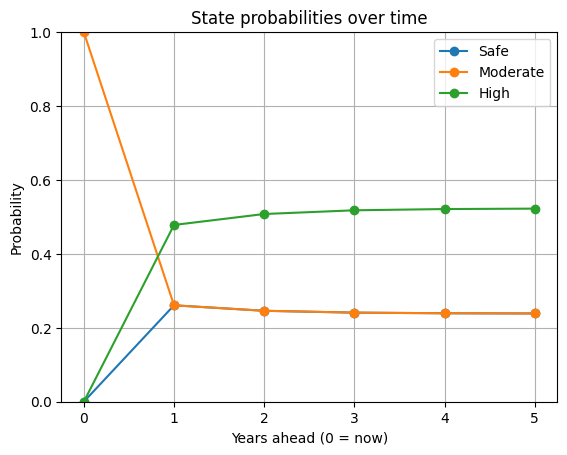

In [290]:
preds = predict_future(1,5, '22.54', '88.74')
print(preds)
plot_state_probs_over_time(preds, n_yrs=5)

### Model training

In [291]:
from sklearn.model_selection import train_test_split

In [292]:
X = data
Y = all_preds
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, Y_train

(        lat       lon  year  state  rain  soil_type  soil_sus  source
 5  22.55162  88.68483  2012      1 -18.0          3       1.0       0
 0  22.54577  88.68517  2015      2  -5.0          3       3.0       4
 7  22.55278  88.68559  2010      2 -10.0          3       3.0       0
 2  22.54577  88.68517  2017      2  -4.0          3       3.0       3
 9  22.55278  88.68559  2012      2  -9.0          3       3.0       0
 4  22.55162  88.68483  2011      0 -19.5          3       1.0       0
 3  22.55162  88.68483  2010      0 -20.0          3       1.0       0
 6  22.55162  88.68483  2013      2 -16.0          3       1.0       0,
 [array([0.        , 1.        , 0.        , 0.26086957, 0.26086957,
         0.47826087, 0.24605228, 0.24605228, 0.50789545, 0.24104496,
         0.24104496, 0.51791007, 0.2393528 , 0.2393528 , 0.52129439,
         0.23878096, 0.23878096, 0.52243808]),
  array([0.        , 0.        , 1.        , 0.15789474, 0.15789474,
         0.68421053, 0.21125325, 0.21

In [293]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

In [294]:
rf_reg = MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42))
rf_reg.fit(X_train, Y_train)

,estimator,RandomForestR...ndom_state=42)
,n_jobs,None
,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [295]:
Y_pred = rf_reg.predict(X_test)
Y_pred

array([[0.11      , 0.01      , 0.96      , 0.18411041, 0.18411041,
        0.63177918, 0.2201125 , 0.2201125 , 0.559775  , 0.23227895,
        0.23227895, 0.53517378, 0.23639044, 0.23639044, 0.52712844,
        0.23779519, 0.23779519, 0.52444026],
       [0.        , 0.01      , 0.995     , 0.15840961, 0.15840961,
        0.68318078, 0.21142724, 0.21142724, 0.57714551, 0.22934387,
        0.22934387, 0.54131225, 0.23539857, 0.23539857, 0.52920286,
        0.23744468, 0.23744468, 0.52511064]])

### Error detection

In [296]:
MSE = mean_squared_error(Y_test, Y_pred)
MSE

0.0005162663384277442

In [297]:
sample = {
    'lat': 0,
    'lon': 0,
    'year': 2025,
    'state': 0,
    'rain': 14.28,
    'soil_type': 2,
    'soil_sus': 1,
    'source': 0
}

sample_X = pd.DataFrame([sample])
pred_vec = rf_reg.predict(sample_X)[0]

# Reshape back: (5 years, n_states)
n_states = global_transition_matrix.shape[0]
pred_probs = pred_vec.reshape(6, n_states)
pred_probs

array([[0.44      , 0.26      , 0.45      ],
       [0.27586834, 0.27586834, 0.44826332],
       [0.25112092, 0.25112092, 0.49775816],
       [0.24275785, 0.24275785, 0.51475264],
       [0.23993165, 0.23993165, 0.52022737],
       [0.23896125, 0.23896125, 0.52204685]])

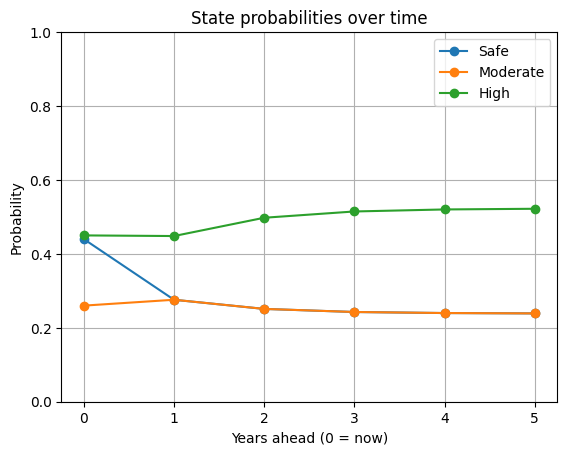

In [298]:
# Visualise
plot_state_probs_over_time(pred_probs, n_yrs=5)

In [299]:
import joblib

In [300]:
joblib.dump(rf_reg, '../model/future_predict_model.joblib')

['../model/future_predict_model.joblib']

In [301]:
import shap

In [302]:
output_idx = 3  # e.g., 1-year ahead, Moderate state
estimator = rf_reg.estimators_[output_idx]
explainer = shap.TreeExplainer(estimator)

sample_df = pd.DataFrame([sample])
shap_vals = explainer.shap_values(sample_df)
shap_vals

array([[ 0.00012872,  0.01063046, -0.00912375,  0.06076574, -0.02874262,
         0.        ,  0.00594565,  0.        ]])

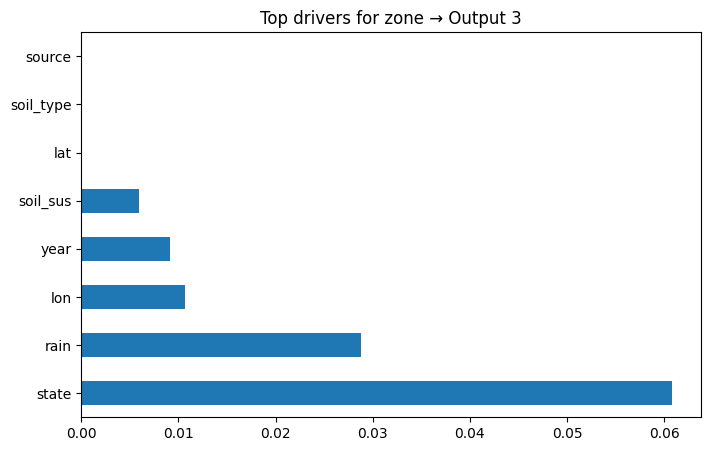

In [303]:

feat_imp_local = pd.Series(shap_vals[0], index=sample_df.columns)
feat_imp_local = feat_imp_local.abs().sort_values(ascending=False)

feat_imp_local.plot(kind='barh', figsize=(8,5))
plt.title(f"Top drivers for zone → Output {output_idx}")
plt.show()
